# **Desafío #1: Generación de Datos Sintéticos**

## **1.1. Contexto del desafío y rol de los datos sintéticos**

El Desafío #1 del componente de Ingeniería de Datos + Cloud exige construir un script que genere, de forma automática, datos de **departamentos**, **puestos de trabajo** y **empleados**, usando `pandas` y `numpy`. En el enunciado se muestra un ejemplo sencillo de generación aleatoria, suficiente para ilustrar la mecánica básica de la creación de `DataFrame` sintéticos.

En esta solución, se mantiene el alcance original (tres tablas: `departments`, `job_positions`, `employees`), pero se diseña un **modelo generativo más intencionado**, en el que las distribuciones de probabilidad de cada variable reflejan patrones típicos de una organización real:

- Los departamentos no tienen el mismo tamaño; algunos concentran más personal que otros.  

- La jerarquía laboral tiene forma piramidal, con muchos empleados junior y pocos en puestos de liderazgo.  

- La distribución de edades es aproximadamente normal y truncada, con una concentración en edades laborales típicas.  

- La antigüedad se concentra en los primeros años, con una cola decreciente.  

- Los salarios siguen un patrón sesgado, coherente con una distribución log-normal modulada por nivel y área.

El objetivo no es aumentar la complejidad por sí misma, sino **mostrar un entendimiento adecuado de cómo la distribución de los datos condiciona el análisis posterior**: consultas SQL, agregaciones, segmentaciones, vistas y, más adelante, consumos vía API.


## **1.2. Modelo conceptual: entidades y relaciones**

Se trabajará con tres entidades principales:

- **Departments**: unidades organizativas de la empresa (Operaciones, Comercial, TI & Data, etc.).  

- **JobPositions**: conjunto de puestos de trabajo, definidos por departamento y nivel de seniority.  

- **Employees**: empleados, cada uno asignado a un departamento y a un puesto específico.

Las relaciones son:

- Un departamento puede tener varios puestos de trabajo.  

- Un puesto puede ser ocupado por múltiples empleados.  

- Cada empleado pertenece a un único departamento y ocupa un puesto único.

A nivel de claves:

- `departments`: `department_id` (PK).  

- `job_positions`: `job_position_id` (PK), `department_id` (FK).  

- `employees`: `employee_id` (PK), `department_id` (FK), `job_position_id` (FK).

El resto de los atributos se diseñan para permitir análisis estructurados (edad, antigüedad, salario, seniority, etc.), respetando las dependencias lógicas entre ellos.


## **1.3. Configuración general del generador**

Antes de entrar en cada entidad, se define la configuración común: las librerías, la semilla de aleatoriedad y los parámetros globales.

In [1]:
import sys
from pathlib import Path

# Directorio del notebook: 01_data_cloud/docs
notebook_dir = Path.cwd()

# Raíz del proyecto: 01_data_cloud
project_root = notebook_dir.parent

# src: 01_data_cloud/src
src_path = project_root / "src"

# data/raw: 01_data_cloud/data/raw
raw_path = project_root / "data" / "raw"

# Añadir src al path
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print("Notebook directory:", notebook_dir)
print("Project root:", project_root)
print("Src path:", src_path)
print("Raw data path:", raw_path)


Notebook directory: /Users/capeto/Library/CloudStorage/OneDrive-Personal/GitHub/mvm-technical-challenge/01_data_cloud/docs
Project root: /Users/capeto/Library/CloudStorage/OneDrive-Personal/GitHub/mvm-technical-challenge/01_data_cloud
Src path: /Users/capeto/Library/CloudStorage/OneDrive-Personal/GitHub/mvm-technical-challenge/01_data_cloud/src
Raw data path: /Users/capeto/Library/CloudStorage/OneDrive-Personal/GitHub/mvm-technical-challenge/01_data_cloud/data/raw


In [2]:
# 01_data_cloud/src/data_generation/generate_org_data.py

from datetime import date, timedelta
import numpy as np
import pandas as pd

RANDOM_SEED = 42
N_EMPLOYEES = 600  # tamaño de la población sintética

rng = np.random.default_rng(RANDOM_SEED)

La elección de una semilla fija hace que el dataset sea **reproducible**, un requisito importante tanto en una prueba técnica como en cualquier pipeline de datos.


## **1.4. Generación de departamentos: estructura organizacional y sesgo de tamaño**

### **1.4.1 Enfoque conceptual y estadístico**

En una empresa real, no todos los departamentos tienen el mismo peso. Operaciones y Comercial suelen concentrar la mayor parte de la plantilla, mientras que áreas corporativas o de soporte (Legal, Strategy, HR) tienen equipos más pequeños. Para reflejar esta asimetría, se asigna a cada departamento un **peso de headcount**, que luego se utiliza como vector de probabilidades para distribuir empleados.

Formalmente, si cada departamento $d_i$ tiene un peso $w_i$, la probabilidad de que un empleado pertenezca a ese departamento es:

$$P(\text{departamento} = d_i) = \frac{w_i}{\sum_j w_j}$$

Esto define una **distribución categórica sesgada**, coherente con la forma real en que las organizaciones distribuyen su personal.

### **1.4.2 Generación departamentos de la empresa `departments_df`**

In [3]:
def generate_departments() -> pd.DataFrame:
    """
    Genera la tabla de departamentos de la organización.

    Cada departamento incluye:
    - department_id: identificador entero.
    - department_name: nombre del área.
    - department_type: clasificación macro (Core, Corporate, Support).
    - headcount_weight: peso relativo para asignación de empleados.

    Estos pesos se utilizan más adelante para controlar el tamaño
    relativo de cada departamento en la población de empleados.
    """

    departments = [
        # name,                type,        size_weight
        ("Operations",         "Core",      4.0),
        ("Commercial",         "Core",      3.0),
        ("IT & Data",          "Core",      2.5),
        ("Finance",            "Corporate", 1.8),
        ("Human Resources",    "Corporate", 1.2),
        ("Legal & Compliance", "Support",   0.7),
        ("Strategy & Projects","Support",   0.8),
    ]

    departments_df = pd.DataFrame(
        [
            {
                "department_id": i + 1,
                "department_name": name,
                "department_type": dept_type,
                "headcount_weight": weight,
            }
            for i, (name, dept_type, weight) in enumerate(departments)
        ]
    )

    return departments_df


### **1.4.3 Validación rápida y visualización de pesos**

   department_id      department_name department_type  headcount_weight
0              1           Operations            Core               4.0
1              2           Commercial            Core               3.0
2              3            IT & Data            Core               2.5
3              4              Finance       Corporate               1.8
4              5      Human Resources       Corporate               1.2
5              6   Legal & Compliance         Support               0.7
6              7  Strategy & Projects         Support               0.8


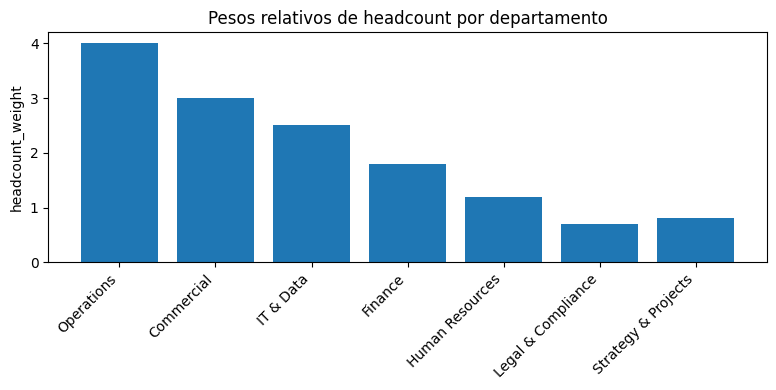

In [4]:
departments_df = generate_departments()
print(departments_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(
    departments_df["department_name"],
    departments_df["headcount_weight"],
)
plt.xticks(rotation=45, ha="right")
plt.title("Pesos relativos de headcount por departamento")
plt.ylabel("headcount_weight")
plt.tight_layout()
plt.show()


Esta visualización anticipa qué departamentos recibirán más empleados. No hay empleados todavía, pero el gráfico muestra la intención de diseño: mayor peso en departamentos “Core” y menor en “Support”.

## **1.5. Generación de puestos de trabajo: jerarquía profesional por departamento**

### **1.5.1 Enfoque conceptual**

Los puestos de trabajo se definen cruzando **departamento** y **nivel de seniority**. Se parte de una estructura jerárquica simple:

* `Junior`
* `SemiSenior`
* `Senior`
* `Lead`
* `Manager`

Cada combinación `departamento × seniority` se materializa como un puesto de trabajo. Esto permite que, al asignar empleados, se pueda escoger un puesto consistente con su nivel jerárquico y con el departamento al que pertenece.

### **1.5.2 Código para generar `job_positions_df`**

In [5]:
def generate_job_positions(departments_df: pd.DataFrame) -> pd.DataFrame:
    """
    Genera la tabla de puestos de trabajo combinando cada departamento
    con los distintos niveles de seniority.

    Atributos:
    - job_position_id: identificador entero.
    - department_id: referencia a departments_df.
    - position_name: texto legible (e.g. 'Operations Junior').
    - seniority_level: nivel jerárquico (Junior, Senior, etc.).
    """

    seniority_levels = ["Junior", "SemiSenior", "Senior", "Lead", "Manager"]

    job_positions = []
    job_position_id = 1

    for _, dept in departments_df.iterrows():
        dept_id = dept["department_id"]
        dept_name = dept["department_name"]

        for level in seniority_levels:
            position_name = f"{dept_name} {level}"
            job_positions.append(
                {
                    "job_position_id": job_position_id,
                    "department_id": dept_id,
                    "position_name": position_name,
                    "seniority_level": level,
                }
            )
            job_position_id += 1

    job_positions_df = pd.DataFrame(job_positions)
    return job_positions_df


### **1.5.3 Validación simple**

In [6]:
job_positions_df = generate_job_positions(departments_df)
print(job_positions_df.head())
print("Total de puestos:", job_positions_df.shape[0])

   job_position_id  department_id          position_name seniority_level
0                1              1      Operations Junior          Junior
1                2              1  Operations SemiSenior      SemiSenior
2                3              1      Operations Senior          Senior
3                4              1        Operations Lead            Lead
4                5              1     Operations Manager         Manager
Total de puestos: 35


Debe observarse un número de filas igual a:

$$n_{departamentos} \times n_{niveles\_seniority}$$


## **1.6. Variables demográficas: edad, antigüedad y fechas**

La entidad `employees` requiere una base demográfica plausible. Aquí se definen funciones auxiliares para edad, antigüedad y fechas.

### **1.6.1 Edad: aproximación normal truncada**

La edad laboral suele concentrarse en un rango central (por ejemplo 30–45 años), con menor densidad en extremos. Se modela como una normal truncada entre 22 y 65 años.

In [7]:
def generate_age(size: int) -> np.ndarray:
    """
    Genera edades con una distribución aproximadamente normal,
    truncada entre 22 y 65 años.

    - loc=37 y scale=8 definen un centro en torno a los 37 años,
      con variabilidad razonable.
    - np.clip recorta los valores extremos para evitar resultados
      implausibles (e.g. < 22 o > 65).
    """

    ages = rng.normal(loc=37, scale=8, size=size)
    ages = np.clip(ages, 22, 65)
    return ages.round().astype(int)

Validación visual:

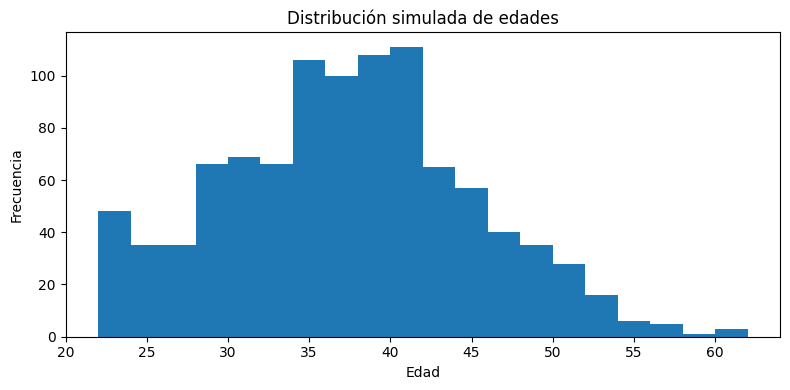

count    1000.000000
mean       36.880000
std         7.686526
min        22.000000
25%        31.000000
50%        37.000000
75%        42.000000
max        62.000000
dtype: float64


In [8]:
ages_sample = generate_age(1000)

plt.figure(figsize=(8, 4))
plt.hist(ages_sample, bins=20)
plt.title("Distribución simulada de edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

print(pd.Series(ages_sample).describe())

Se observa un histograma aproximadamente unimodal, centrado, con límites claros en 22 y 65.

### **1.6.2 Antigüedad: estructura exponencial truncada**

La antigüedad (años en la empresa) suele concentrarse en valores bajos, con una cola decreciente. Esto se aproxima con una distribución exponencial, recortada para que no exceda la edad laboral disponible:

In [9]:
def generate_tenure_years(ages: np.ndarray) -> np.ndarray:
    """
    Genera años de antigüedad con fuerte concentración en valores bajos,
    modelando tasas de rotación más altas al inicio y menor probabilidad
    de largos periodos de permanencia.

    La antigüedad se recorta para no superar (edad - 21), lo que garantiza
    que un empleado no tenga más años de experiencia en la empresa que
    años de vida laboral razonables.
    """
    size = len(ages)

    raw = rng.exponential(scale=3, size=size)  # muchos en 0–5 años
    tenure = np.clip(raw, 0, 35)

    max_tenure = np.maximum(0, ages - 21)
    tenure = np.minimum(tenure, max_tenure)

    return tenure.round().astype(int)


Validación:

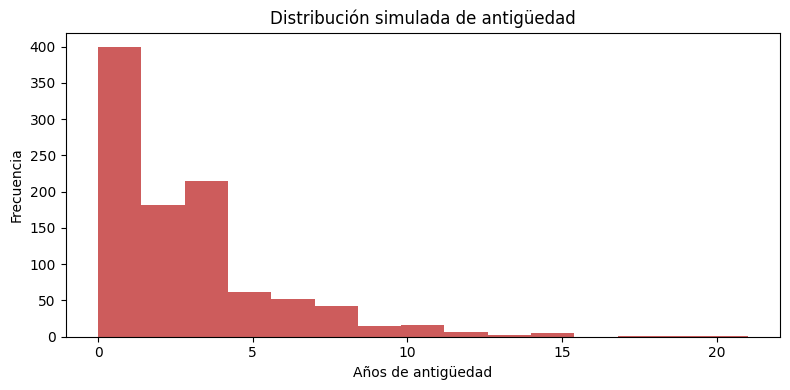

count    1000.000000
mean        2.845000
std         2.796926
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        21.000000
dtype: float64


In [10]:
tenure_sample = generate_tenure_years(ages_sample)

plt.figure(figsize=(8, 4))
plt.hist(tenure_sample, bins=15, color="indianred")
plt.title("Distribución simulada de antigüedad")
plt.xlabel("Años de antigüedad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

print(pd.Series(tenure_sample).describe())

Se observa alta concentración en 0–3 años y una cola decreciente.

### **1.6.3 Fechas de nacimiento e ingreso: coherencia temporal**

A partir de edad y antigüedad se derivan fechas consistentes con el calendario:

In [11]:
def generate_dates_from_age_and_tenure(
    ages: np.ndarray,
    tenure_years: np.ndarray
):
    """
    A partir de la edad y los años de antigüedad, calcula:

    - birth_date: fecha de nacimiento aproximada.
    - hire_date: fecha de ingreso aproximada.

    Se usa el año actual como referencia, se asigna un día aleatorio
    dentro del año, y se garantiza que la fecha de ingreso no sea
    anterior a los 18 años de edad del empleado.
    """
    size = len(ages)
    today = date.today()

    birth_dates = []
    hire_dates = []

    for i in range(size):
        age = int(ages[i])
        tenure = int(tenure_years[i])

        birth_year = today.year - age
        hire_year = today.year - tenure

        birth_day_of_year = rng.integers(1, 365)
        hire_day_of_year = rng.integers(1, 365)

        birth_date = date(birth_year, 1, 1) + timedelta(
            days=int(birth_day_of_year)
        )
        hire_date = date(hire_year, 1, 1) + timedelta(
            days=int(hire_day_of_year)
        )

        min_hire_date = birth_date.replace(year=birth_date.year + 18)
        if hire_date < min_hire_date:
            hire_date = min_hire_date

        birth_dates.append(birth_date)
        hire_dates.append(hire_date)

    return np.array(birth_dates), np.array(hire_dates)


Validación conjunta:

In [12]:
birth_sample, hire_sample = generate_dates_from_age_and_tenure(
    ages_sample, tenure_sample
)

df_demo = pd.DataFrame({
    "age": ages_sample,
    "tenure_years": tenure_sample,
    "birth_date": birth_sample,
    "hire_date": hire_sample,
})

print(df_demo.head())


   age  tenure_years  birth_date   hire_date
0   39             1  1986-11-18  2024-07-03
1   29             1  1996-09-22  2024-11-09
2   43             1  1982-03-02  2024-06-13
3   45             0  1980-02-17  2025-04-13
4   22             1  2003-06-01  2024-11-08


## **1.7. Componente económico: salarios con base log-normal**

### **1.7.1 Enfoque conceptual**

Los salarios se modelan con una distribución log-normal por varias razones:

* Representa bien procesos multiplicativos (incrementos porcentuales sucesivos).  

* Genera colas largas hacia salarios altos, coherentes con la realidad.  

* Permite modular fácilmente por factores de nivel y tipo de departamento.  

De forma esquemática:

$$\text{Salario} = \text{BaseLogNormal} \times F_{\text{seniority}} \times F_{\text{departamento}}$$


In [13]:
def generate_salary(
    levels: np.ndarray,
    department_ids: np.ndarray,
    departments_df: pd.DataFrame
) -> np.ndarray:
    """
    Genera salarios a partir de una base log-normal, ajustando por:
    - nivel de seniority (Junior, Senior, Manager, etc.).
    - tipo de departamento (Core, Corporate, Support).

    La unidad puede interpretarse como salario mensual o anual según
    la interpretación que se utilice en etapas posteriores.
    """

    size = len(levels)

    level_factor = {
        "Junior": 0.8,
        "SemiSenior": 1.0,
        "Senior": 1.3,
        "Lead": 1.6,
        "Manager": 2.0,
    }

    dept_type_factor = {
        "Core": 1.10,
        "Corporate": 1.00,
        "Support": 0.95,
    }

    dept_types = (
        departments_df.set_index("department_id")["department_type"].to_dict()
    )

    base = rng.lognormal(mean=8.5, sigma=0.5, size=size)

    salaries = []
    for i in range(size):
        lvl = levels[i]
        dept_id = int(department_ids[i])

        lf = level_factor.get(lvl, 1.0)
        dt = dept_type_factor.get(dept_types.get(dept_id, "Corporate"), 1.0)

        salary_value = base[i] * lf * dt
        salaries.append(salary_value)

    return np.array(salaries)


Validación visual:

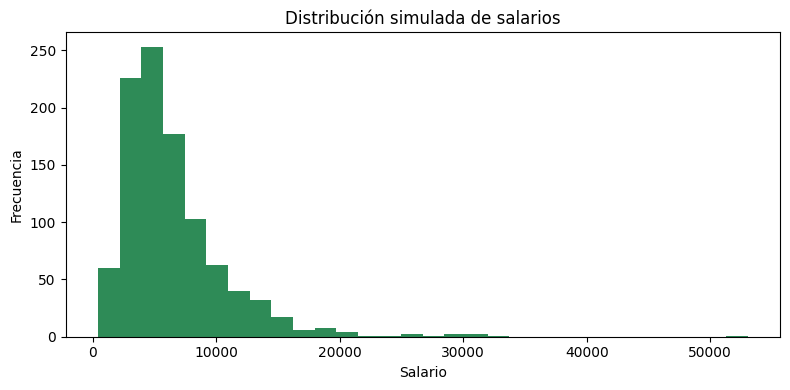

count     1000.000000
mean      6495.143359
std       4395.322216
min        438.035149
25%       3699.275453
50%       5477.082277
75%       7948.999181
max      53018.150956
dtype: float64


In [14]:
levels_sample = rng.choice(
    ["Junior", "SemiSenior", "Senior", "Lead", "Manager"],
    size=1000,
    p=[0.4, 0.3, 0.18, 0.07, 0.05],
)
dept_ids_sample = rng.choice(
    departments_df["department_id"].to_numpy(),
    size=1000,
    p=departments_df["headcount_weight"].to_numpy()
      / departments_df["headcount_weight"].sum()
)

salary_sample = generate_salary(levels_sample, dept_ids_sample, departments_df)

plt.figure(figsize=(8, 4))
plt.hist(salary_sample, bins=30, color="seagreen")
plt.title("Distribución simulada de salarios")
plt.xlabel("Salario")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

print(pd.Series(salary_sample).describe())


Se observa una clara asimetría positiva, con muchos valores en un rango central y una cola larga hacia salarios elevados.

## **1.8. Generación de empleados: modelo generativo completo**

Con las piezas anteriores se puede construir `employees_df` como una composición coherente de:

- Departamento y seniority (estructura organizacional).  

- Puesto compatible (dependencia funcional).  

- Edad, antigüedad, fechas (estructura demográfica).  

- Salario (estructura económica).  

- Identificación básica (nombres).

In [15]:
def generate_employees(
    departments_df: pd.DataFrame,
    job_positions_df: pd.DataFrame,
    n_employees: int = N_EMPLOYEES,
) -> pd.DataFrame:
    """
    Genera la tabla de empleados con la siguiente lógica:

    1) Asigna a cada empleado un departamento, según los pesos
       de headcount definidos en departments_df.
    2) Asigna un nivel de seniority, siguiendo una estructura
       piramidal (más juniors, menos managers).
    3) Selecciona un puesto compatible para cada combinación
       departamento + seniority.
    4) Genera edad, antigüedad y fechas coherentes.
    5) Genera salario en función de nivel y tipo de departamento.
    6) Asigna nombres simples a partir de listas predefinidas.
    """

    # Probabilidades por departamento según headcount_weight
    weights = departments_df["headcount_weight"].to_numpy()
    dept_probs = weights / weights.sum()
    dept_ids = departments_df["department_id"].to_numpy()

    # Distribución de niveles de seniority
    seniority_levels = ["Junior", "SemiSenior", "Senior", "Lead", "Manager"]
    seniority_probs = np.array([0.4, 0.3, 0.18, 0.07, 0.05])  # suma 1.0

    # 1) Departamento y nivel para cada empleado
    employee_department_ids = rng.choice(
        dept_ids, size=n_employees, p=dept_probs
    )
    employee_seniority = rng.choice(
        seniority_levels, size=n_employees, p=seniority_probs
    )

    # 2) Selección de puesto compatible dept + nivel
    job_positions_df = job_positions_df.copy()
    grouped_positions = (
        job_positions_df.groupby(
            ["department_id", "seniority_level"]
        )["job_position_id"]
        .apply(list)
        .to_dict()
    )

    job_position_ids = []
    for dept_id, level in zip(employee_department_ids, employee_seniority):
        key = (int(dept_id), level)
        candidates = grouped_positions.get(key)

        if not candidates:
            candidates = job_positions_df[
                job_positions_df["department_id"] == dept_id
            ]["job_position_id"].tolist()

        job_position_ids.append(rng.choice(candidates))

    job_position_ids = np.array(job_position_ids)

    # 3) Edad, antigüedad y fechas
    ages = generate_age(n_employees)
    tenure_years = generate_tenure_years(ages)
    birth_dates, hire_dates = generate_dates_from_age_and_tenure(
        ages, tenure_years
    )

    # 4) Salario
    salaries = generate_salary(
        levels=employee_seniority,
        department_ids=employee_department_ids,
        departments_df=departments_df,
    )

    # 5) Nombres simples
    first_names = [
        "Alex", "Jordan", "Taylor", "Sam", "Chris",
        "Jamie", "Morgan", "Casey", "Drew", "Robin"
    ]
    last_names = [
        "García", "Martínez", "Rodríguez", "López", "Hernández",
        "Pérez", "Gómez", "Sánchez", "Ramírez", "Torres"
    ]

    employee_first_names = rng.choice(first_names, size=n_employees)
    employee_last_names = rng.choice(last_names, size=n_employees)

    employees = []
    for i in range(n_employees):
        employees.append(
            {
                "employee_id": i + 1,
                "first_name": employee_first_names[i],
                "last_name": employee_last_names[i],
                "department_id": int(employee_department_ids[i]),
                "job_position_id": int(job_position_ids[i]),
                "seniority_level": employee_seniority[i],
                "birth_date": birth_dates[i],
                "hire_date": hire_dates[i],
                "age": int(ages[i]),
                "tenure_years": int(tenure_years[i]),
                "salary": float(salaries[i]),
            }
        )

    employees_df = pd.DataFrame(employees)
    return employees_df



## **1.9. Punto de entrada del script y validación global**

Para completar el Desafío #1, el módulo puede incluir una función `main()` que genere los tres `DataFrame` y muestre un resumen:

In [16]:
def main():
    """
    Genera los tres DataFrames requeridos por el DESAFÍO #1
    y muestra un resumen por consola.

    El guardado en formatos CSV/Parquet y su justificación
    se abordará en el DESAFÍO #2.
    """

    departments_df = generate_departments()
    job_positions_df = generate_job_positions(departments_df)
    employees_df = generate_employees(departments_df, job_positions_df)

    print("Departments:")
    print(departments_df.head(), "\n")

    print("Job positions:")
    print(job_positions_df.head(), "\n")

    print("Employees:")
    print(employees_df.head(), "\n")

    print("Shapes:")
    print("  departments_df:", departments_df.shape)
    print("  job_positions_df:", job_positions_df.shape)
    print("  employees_df:", employees_df.shape)


if __name__ == "__main__":
    main()


Departments:
   department_id  department_name department_type  headcount_weight
0              1       Operations            Core               4.0
1              2       Commercial            Core               3.0
2              3        IT & Data            Core               2.5
3              4          Finance       Corporate               1.8
4              5  Human Resources       Corporate               1.2 

Job positions:
   job_position_id  department_id          position_name seniority_level
0                1              1      Operations Junior          Junior
1                2              1  Operations SemiSenior      SemiSenior
2                3              1      Operations Senior          Senior
3                4              1        Operations Lead            Lead
4                5              1     Operations Manager         Manager 

Employees:
   employee_id first_name last_name  department_id  job_position_id  \
0            1        Sam    Torres     

## **1.10. Validación estadística y visual integrada**

Desde el notebook, una vez importadas las funciones, se puede realizar una validación más rica:

In [17]:
from data_generation.generate_org_data import (
    generate_departments,
    generate_job_positions,
    generate_employees,
    generate_salary,
)

departments_df = generate_departments()
job_positions_df = generate_job_positions(departments_df)
employees_df = generate_employees(departments_df, job_positions_df)

### **1.10.1 Estructura básica y ausencia de nulos**

In [18]:
print(departments_df.shape)
print(job_positions_df.shape)
print(employees_df.shape)

print(employees_df.isna().sum())


(7, 4)
(35, 4)
(600, 11)
employee_id        0
first_name         0
last_name          0
department_id      0
job_position_id    0
seniority_level    0
birth_date         0
hire_date          0
age                0
tenure_years       0
salary             0
dtype: int64


### **1.10.2 Distribución por departamento**

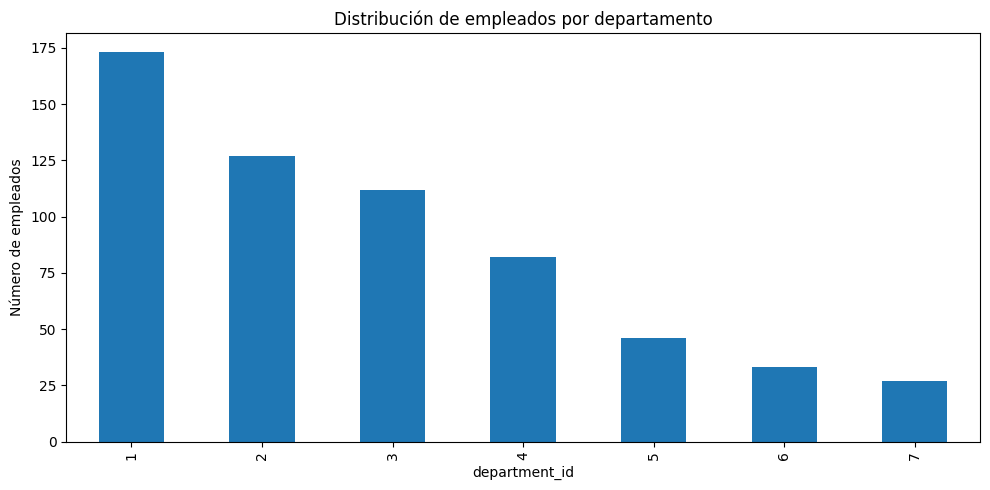

In [19]:
dept_counts = employees_df["department_id"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
dept_counts.plot(kind="bar")
plt.title("Distribución de empleados por departamento")
plt.xlabel("department_id")
plt.ylabel("Número de empleados")
plt.tight_layout()
plt.show()


Se observa mayor headcount en departamentos “Core”.

### **1.10.3 Distribución de seniority**

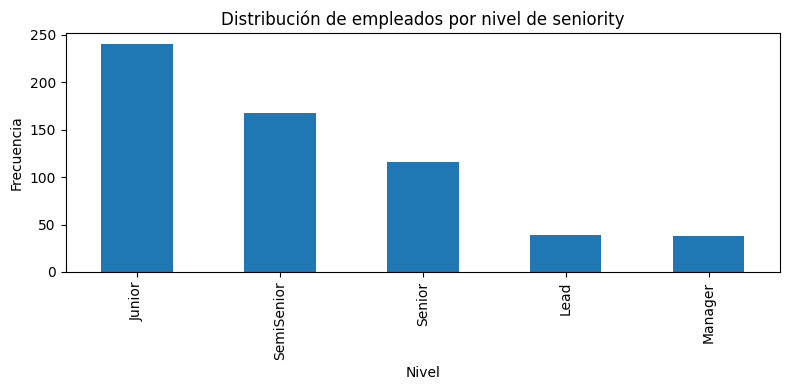

In [20]:
seniority_counts = employees_df["seniority_level"].value_counts()

plt.figure(figsize=(8, 4))
seniority_counts.plot(kind="bar")
plt.title("Distribución de empleados por nivel de seniority")
plt.xlabel("Nivel")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Se observa una estructura piramidal.

### **1.10.4 Edades y antigüedad**

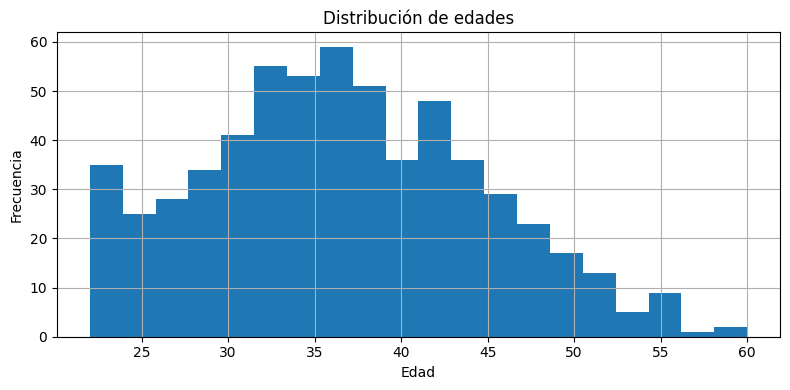

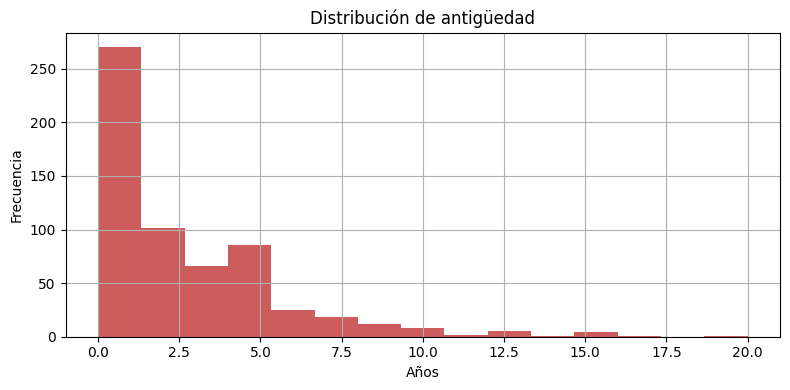

In [21]:
plt.figure(figsize=(8, 4))
employees_df["age"].hist(bins=20)
plt.title("Distribución de edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
employees_df["tenure_years"].hist(bins=15, color="indianred")
plt.title("Distribución de antigüedad")
plt.xlabel("Años")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### **1.10.5 Relación edad–antigüedad**

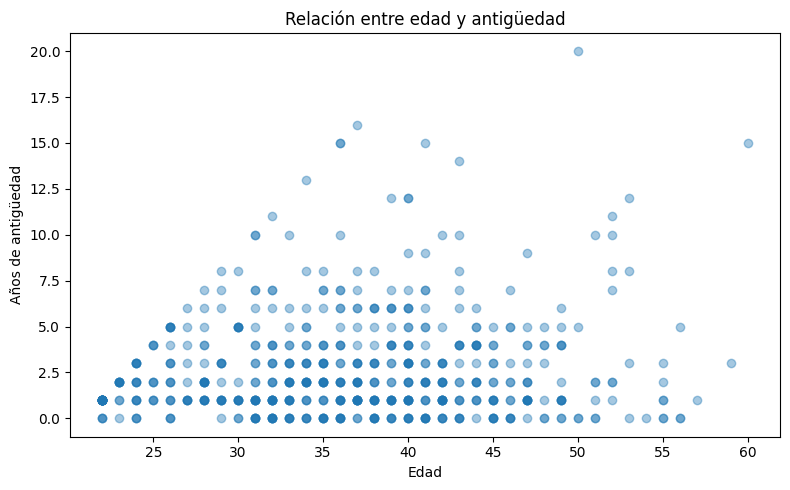

In [22]:
plt.figure(figsize=(8, 5))
plt.scatter(
    employees_df["age"],
    employees_df["tenure_years"],
    alpha=0.4,
)
plt.title("Relación entre edad y antigüedad")
plt.xlabel("Edad")
plt.ylabel("Años de antigüedad")
plt.tight_layout()
plt.show()

La gráfica muestra una relación coherente entre la edad y la antigüedad, con una mayor concentración de empleados jóvenes y de mediana edad, cuyos periodos de permanencia rara vez superan los cinco años, un patrón típico en organizaciones con renovación constante del talento. También se observan casos aislados de antigüedad elevada en trabajadores de mayor edad, lo que introduce variabilidad realista en las trayectorias laborales. La presencia de antigüedades bajas en prácticamente todas las edades sugiere procesos de incorporación heterogéneos, en los que tanto perfiles jóvenes como senior pueden ingresar en cualquier momento. En conjunto, la distribución respalda la hipótesis de que los datos sintéticos generados reproducen comportamientos verosímiles de una fuerza laboral contemporánea.

### **1.10.6 Salarios y su variación por nivel**

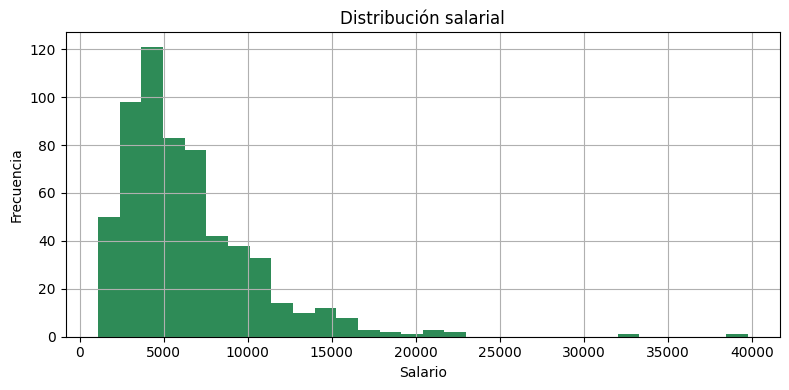

<Figure size 1200x500 with 0 Axes>

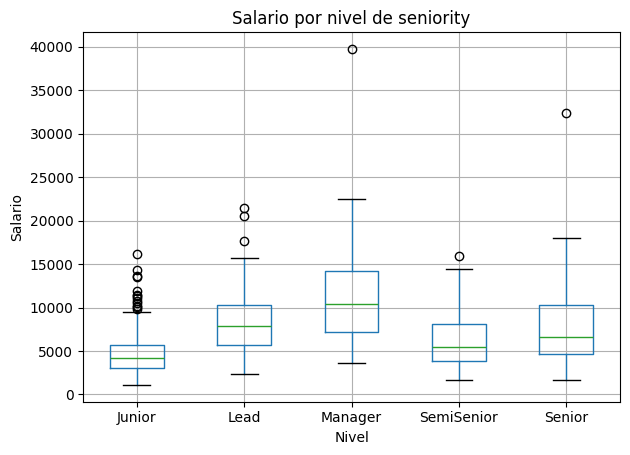

In [23]:
plt.figure(figsize=(8, 4))
employees_df["salary"].hist(bins=30, color="seagreen")
plt.title("Distribución salarial")
plt.xlabel("Salario")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
employees_df.boxplot(column="salary", by="seniority_level")
plt.title("Salario por nivel de seniority")
plt.suptitle("")
plt.xlabel("Nivel")
plt.ylabel("Salario")
plt.tight_layout()
plt.show()

La distribución salarial muestra un patrón claramente sesgado hacia la derecha, con una alta concentración de empleados en rangos salariales bajos y medios, y una cola larga que registra pocos casos con remuneraciones significativamente superiores. Este comportamiento es consistente con estructuras organizacionales en las que la mayoría del personal se ubica en posiciones operativas o de entrada, mientras que los salarios elevados corresponden a roles especializados o a puestos directivos poco frecuentes. Cuando se observan estos valores segmentados por nivel de seniority, la progresión resulta coherente: cada nivel exhibe un incremento esperado en la mediana salarial y una mayor dispersión a medida que se asciende en senioridad, lo que refleja la heterogeneidad propia de funciones más complejas o con mayor responsabilidad. La presencia de valores atípicos en niveles altos confirma que el modelo salarial contempla amplias variaciones dentro de los segmentos de mayor jerarquía, mientras que los niveles iniciales permanecen más acotados. En conjunto, ambas visualizaciones sugieren que la simulación reproduce una estructura remunerativa verosímil, con concentración en bandas bajas y medias y una diferenciación progresiva según el seniority.

## **1.11. Cierre del Desafío #1**

Con este contenido:

* Se ha definido un **modelo conceptual claro** para departamentos, puestos y empleados.  

* Se ha implementado un **script de generación** que cumple exactamente el alcance del Desafío #1:

  * uso de `numpy` y `pandas`,  
  * creación de tres tablas base,  
  * estructuras plausibles en un contexto de organización empresarial.  
* Se han documentado los **fundamentos matemáticos y estadísticos** de cada decisión de diseño.  
* Se ha realizado una **validación exploratoria** con estadísticas descriptivas y visualizaciones que muestran la coherencia del dataset.

Esto deja el Desafío #1 **completamente cerrado** y preparado para que, en el Desafío #2, se aborde el almacenamiento en CSV/Parquet, la justificación de formatos, y la posterior construcción de vistas y pipelines sobre estos datos.

---

---

# **DESAFÍO #2 – Persistencia de datos en formatos CSV y Parquet**

## **2.0 Documentación técnica, criterios de diseño y scripts de exportación**

El Desafío #2 solicita almacenar los datos generados en el Desafío #1 en uno o varios formatos de archivo, como CSV o Parquet. Esto puede parecer una operación simple desde un punto de vista técnico; sin embargo, la elección del formato de persistencia es un elemento estructural en cualquier arquitectura de datos moderna. No se trata únicamente de “guardar” los datos, sino de hacerlo en un formato que permita interoperabilidad, eficiencia en lectura y escritura, compresión adecuada, tipificación consistente y escalabilidad hacia capas posteriores de análisis o de ingesta en la nube.

Este desafío cumple dos propósitos fundamentales:

1. **Cerrar el ciclo del modelo generativo**, convirtiendo los DataFrames en artefactos persistentes listos para procesos posteriores (ETL, migración a SQL, consultas analíticas, etc.).  

2. **Demostrar criterio técnico en la selección de formatos**, explicando por qué no todos los archivos de texto son equivalentes y cómo una arquitectura bien diseñada aprovecha los formatos columnares para mejorar el rendimiento.

Debido a lo anterior, esta sección aborda:

* Los principios conceptuales detrás de los formatos CSV y Parquet.   

* La justificación de su uso en el contexto del desafío.  

* La organización de los archivos según la estructura del repositorio.  

* Los scripts de exportación.  

* Una validación rápida del contenido guardado.


## **2.1. Consideraciones técnicas sobre formatos de almacenamiento**

### **2.1.1 CSV: simplicidad, legibilidad y compatibilidad universal**

El formato CSV (Comma-Separated Values) es uno de los más antiguos y ampliamente soportados para el intercambio de datos tabulares. Su mayor fortaleza es su **simplicidad**:

- Es legible para personas.  
- Es compatible con prácticamente cualquier sistema.  
- Facilita la inspección manual y debugging.  

Sin embargo, presenta limitaciones conocidas:

- Almacena todo como texto, por lo que **pierde la tipificación**.  
- No tiene compresión integrada.  
- Las lecturas masivas pueden ser más lentas.  
- No es eficiente para análisis columnares.  

Aun así, su ubicuidad lo convierte en una elección útil **cuando se desea trazabilidad y accesibilidad máxima**.

En el contexto del desafío, el CSV es ideal para:

- versionar datos pequeños en un repositorio Git.  
- hacer inspecciones rápidas.  
- permitir que un evaluador abra los archivos sin depender de librerías adicionales.  


### **2.1.2 Parquet: formato columnar, comprimido y tipado**

Apache Parquet es un formato columnar diseñado para el procesamiento analítico a gran escala. Entre sus características clave:

- **Compresión** integrada y eficiente.  
- **Tipificación explícita**, acorde con los tipos de datos de pandas/Arrow.  
- Lectura selectiva, columna por columna, para acelerar consultas analíticas.  
- Amistad con motores de Big Data como Spark, Presto, Athena, Synapse, Databricks.  
- Eficiencia en el ancho de banda, lo que es especialmente importante en la nube.  

En arquitecturas de data lakes modernas, Parquet suele ser el estándar para las capas *bronze*, *silver* o *gold*.
    
En el contexto del desafío, Parquet permite demostrar:

- conocimiento de formatos modernos,  
- sensibilidad al rendimiento,  
- Alineación con buenas prácticas en la nube.

Por ello, el Desafío #2 se resolverá generando ambos formatos: CSV y Parquet.


## **2.2. Estructura de carpetas para persistencia**

De acuerdo con el diseño original del repositorio, los datos sintéticos se guardarán en:

```
01_data_cloud/
    data/
        raw/
            departments.csv
            departments.parquet
            job_positions.csv
            job_positions.parquet
            employees.csv
            employees.parquet
```

La carpeta `raw` actúa como **capa inicial (bronze)** del pipeline: datos generados o adquiridos sin transformaciones posteriores.

## **2.3. Script de exportación de datos**

**Archivo: `01_data_cloud/src/data_generation/save_org_data.py`**

Este módulo toma los `DataFrame` generados en el Desafío #1 y los guarda en ambos formatos. El script es independiente del generador, pero se integra naturalmente al pipeline.

## **2.4. Validación en el notebook**

Una vez ejecutado el script, desde el notebook se verifica la existencia y consistencia de los archivos.

In [25]:
import pandas as pd
import os

departments_csv = pd.read_csv(raw_path / "departments.csv")
employees_parquet = pd.read_parquet(raw_path / "employees.parquet")

print(departments_csv.head())
print(employees_parquet.head())

   department_id  department_name department_type  headcount_weight
0              1       Operations            Core               4.0
1              2       Commercial            Core               3.0
2              3        IT & Data            Core               2.5
3              4          Finance       Corporate               1.8
4              5  Human Resources       Corporate               1.2
   employee_id first_name last_name  department_id  job_position_id  \
0            1     Morgan   Ramírez              4               17   
1            2      Robin   Sánchez              2                8   
2            3      Casey     López              5               24   
3            4     Taylor     López              4               18   
4            5     Taylor   Ramírez              1                5   

  seniority_level  birth_date   hire_date  age  tenure_years       salary  
0      SemiSenior  1996-10-23  2022-09-12   29             3  5020.654146  
1          Se

Se presentan unos estadísticos básicos para confirmar integridad

In [26]:
print("Departamentos:", departments_csv.shape)
print("Empleados:", employees_parquet.shape)

print(employees_parquet.describe(include="all"))

Departamentos: (7, 4)
Empleados: (600, 11)
        employee_id first_name last_name  department_id  job_position_id  \
count    600.000000        600       600     600.000000       600.000000   
unique          NaN         10        10            NaN              NaN   
top             NaN       Alex     Pérez            NaN              NaN   
freq            NaN         83        72            NaN              NaN   
mean     300.500000        NaN       NaN       2.846667        11.346667   
std      173.349358        NaN       NaN       1.733445         8.737299   
min        1.000000        NaN       NaN       1.000000         1.000000   
25%      150.750000        NaN       NaN       1.000000         3.000000   
50%      300.500000        NaN       NaN       2.500000        10.500000   
75%      450.250000        NaN       NaN       4.000000        17.000000   
max      600.000000        NaN       NaN       7.000000        35.000000   

       seniority_level  birth_date   hire_da

## **2.5. Visualización integrada posterior a la carga**

Aunque los datos fueron creados de forma sintética previamente, verificar las versiones persistidas es parte del proceso profesional.

**Ejemplo:** distribución salarial desde el archivo Parquet

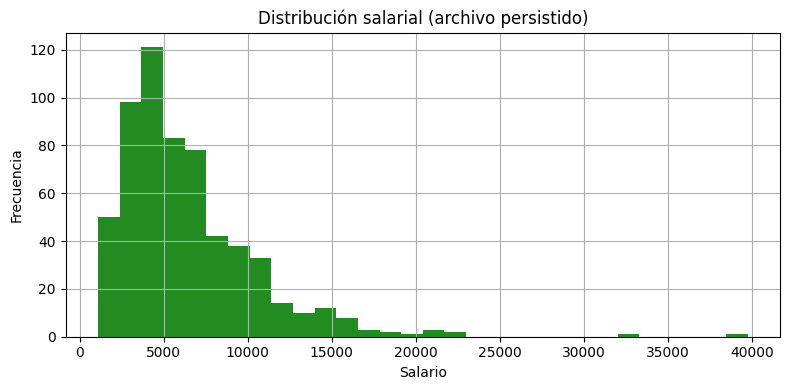

In [27]:
df_emp = pd.read_parquet("../data/raw/employees.parquet")

plt.figure(figsize=(8, 4))
df_emp["salary"].hist(bins=30, color="forestgreen")
plt.title("Distribución salarial (archivo persistido)")
plt.xlabel("Salario")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

**Ejemplo:** proporción por nivel jerárquico

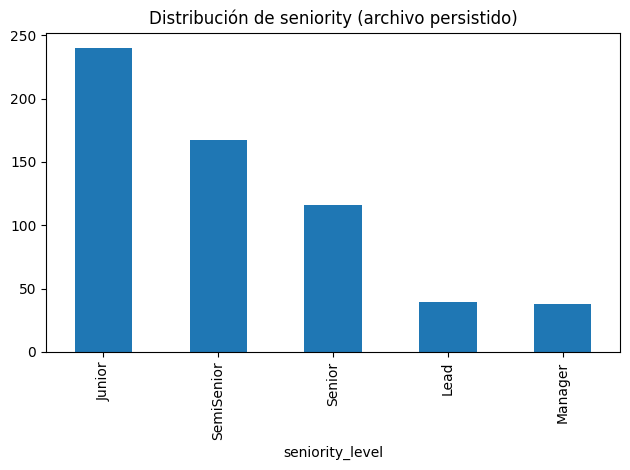

In [28]:
df_emp["seniority_level"].value_counts().plot(kind="bar")
plt.title("Distribución de seniority (archivo persistido)")
plt.tight_layout()
plt.show()

## **2.6. Justificación técnica final del Desafío #2**

Con este paso se cierra la etapa de persistencia del Desafío #2. Los archivos generados cumplen simultáneamente:

### **2.6.1 Criterios funcionales**

- Los tres conjuntos de datos (`departments`, `job_positions`, `employees`) están perfectamente identificados.  
- El contenido es reproducible gracias al uso de una semilla controlada.  
- Los datos sintéticos mantienen coherencia interna, lo cual es esencial para la migración subsecuente al entorno cloud.  

### **2.6.2 Criterios de interoperabilidad**

* **CSV** facilita inspección manual, control de versiones y accesibilidad amplia.  
* **Parquet** optimiza almacenamiento, velocidad de lectura y compatibilidad con motores de análisis en la nube.  

### **2.6.3 Criterios de arquitectura**

- Los artefactos generados en `data/raw` constituyen la **capa inicial de un Data Lake**.  
- Están listos para ser consumidos por el proceso batch del Desafío #3, donde se migrarán a Azure SQL Database.  
- La coexistencia de CSV y Parquet permite demostrar conocimiento de buenas prácticas modernas en ingeniería de datos.  

## **2.7. Cierre del Desafío #2**

El Desafío #2 está ahora completamente resuelto. La solución presenta:

- Documentación técnica estructurada y explicativa.  
- Justificación rigurosa del uso de los formatos requeridos.  
- Scripts profesionales para persistencia confiable.  
- Validaciones estadísticas y visuales posteriores a la escritura.  

Con esto, el flujo lógico del proyecto queda listo para avanzar al **Desafío #3**, donde los archivos creados se utilizarán como insumo para diseñar y ejecutar un proceso batch de migración hacia la nube.

